In [1]:
import sys
import os
SPEC_PIPE_LOC = "{}/JPL/W12_Drops/spec_paper/Spec_pipeline".format(os.path.expanduser("~"))
sys.path.append(SPEC_PIPE_LOC)
os.environ['SPEC_PIPE_LOC'] = SPEC_PIPE_LOC

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from Spec_pipeline import SDSS_Spec, Powc_Line_fit

sys.path.append("../plots/utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Load the properties of the BHDs
wid = "W0204-0506"
op = ObjectProperties([wid])

In [3]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [4]:
#Load the spectra for each BHD, extended using the best-fit SED, although here we will not care about the extension.
specs = ReadExtrapolatedSpectra()
spec = specs.specs.sp[wid]

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [5]:
#Create the spectrum model.
model = Powc_Line_fit(spec=spec)
model.add_line('CIV')
model.add_line('HeII')
model.add_line('CIII]')

In [6]:
#Replace the continuum regions so that the full spectrum is used. 
full_range = np.zeros(2)*u.AA
full_range[0] = 1260.*u.AA
full_range[1] = np.max(spec.lam_rest)
model.multi_line[-1].continuum_regions[1] = full_range

In [7]:
#Run the fitting
model.run_fit()

In [8]:
#Run the MC. 
model.run_MC(1000)

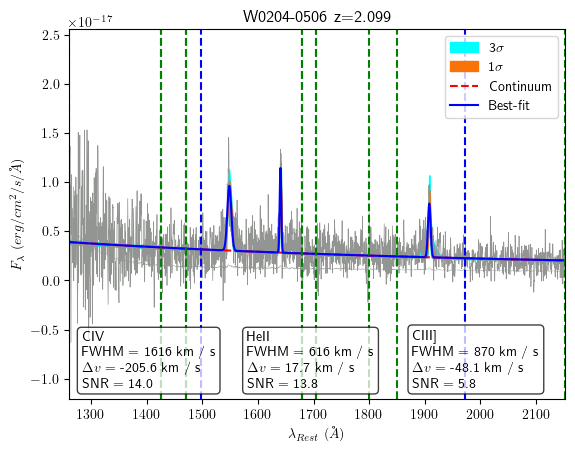

In [9]:
model.line_name = ""
model.plot()

In [13]:
for line in model.multi_line:
    print(line.FWHM_v, line.FWHM_v_low, line.FWHM_v_hig)

[1616.01409327] km / s [173.45155827] km / s [212.35560028] km / s
[615.80813889] km / s [48.22013634] km / s [73.01993173] km / s
[870.16761416] km / s [285.10201613] km / s [417.17566711] km / s


In [40]:
flam_cont_model = model.flam_cont_model(spec.lam_rest)
flam_model = model.flam_model(spec.lam_rest)
flam_model_min = np.zeros(len(flam_model))*flam_model.unit
flam_model_max = np.zeros(len(flam_model))*flam_model.unit
for k, lam_use in enumerate(spec.lam_rest):
    lam_mod_chain = np.tile(lam_use, model.MC_chain.shape[0])
    aux_model = model.flam_model(lam_mod_chain, chain_output=model.MC_chain)
    flam_model_min[k] = np.percentile(aux_model, 100.-95.4)
    flam_model_max[k] = np.percentile(aux_model, 95.4)

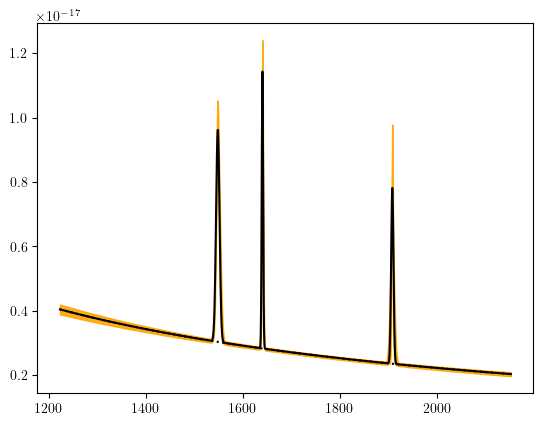

In [44]:
plt.fill_between(spec.lam_rest.value, flam_model_min.value, flam_model_max.value, color='orange', alpha=0.9)
plt.plot(spec.lam_rest, flam_cont_model, 'k', ls='dotted')
plt.plot(spec.lam_rest, flam_model, 'k-')